In [1]:
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import astropy
from matplotlib.pyplot import cm
from astropy import constants as const
from astropy import units as u
import numpy.ma as ma
from scipy.stats import mode
from scipy.misc import imread
import imageio
from lmfit.models import LinearModel, LorentzianModel
import matplotlib.patches as patches
from matplotlib.patches import Circle
from skimage import img_as_float, measure, feature
from skimage.transform import rotate as skrotate
from photutils.centroids import centroid_com
from itertools import combinations
import os
import time
import scipy
import cv2
import old_code as old
import image_separator_laura as ims
from scipy.optimize import curve_fit


The Stack part is missing


In [2]:
#test = ims.sun_img('20111114174014Mh.jpg') #problems here
#test = ims.sun_img('20111114175814Mh.jpg') #it is the same moment
test = ims.sun_img('20111114232414Mh.jpg') #works
#test = ims.sun_img('fc2_save_2018-12-04-143943-0000.jpg')

#test = ims.sun_img('20120928004014Mh.jpg')
#test = ims.sun_img('20111128001114Mh.jpg')


In [3]:
a, b = ims.sun_img.separate_images(test)

r = ims.sun_img.circle_properties(test)[0][2]
x = ims.sun_img.circle_properties(test)[0][0]
y = ims.sun_img.circle_properties(test)[0][1]

center = (x,y)

print(center)
print(r)

(152, 154)
135


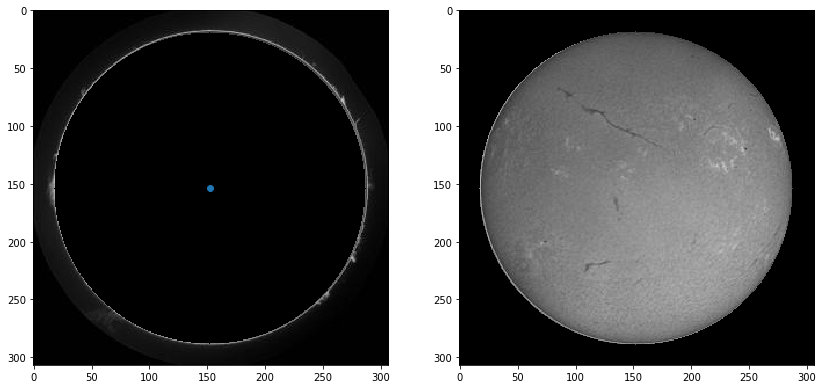

In [4]:
fig1 = plt.figure(figsize=(14,8))
plt.subplot(1, 2, 1)
plt.imshow(a)
plt.scatter(x,y)


plt.subplot(1, 2, 2)
plt.imshow(b)

plt.show()

In [5]:
## Add circles to test transformation
# cv2.circle(a,(x+r,y), 5, (0,0,255), -1)
# cv2.circle(a,(x-r,y), 5, (0,0,255), -1)
# cv2.circle(a,(x,y+r), 5, (0,0,255), -1)
# cv2.circle(a,(x,y-r), 5, (0,0,255), -1)

In [6]:
flat = cv2.linearPolar(a, center,r+50,cv2.WARP_FILL_OUTLIERS)
recover = cv2.linearPolar(flat, center,r+50,cv2.WARP_FILL_OUTLIERS+cv2.WARP_INVERSE_MAP)
print(np.shape(a))

(307, 307, 3)


## Make it so it starts cutting where there is nothing?

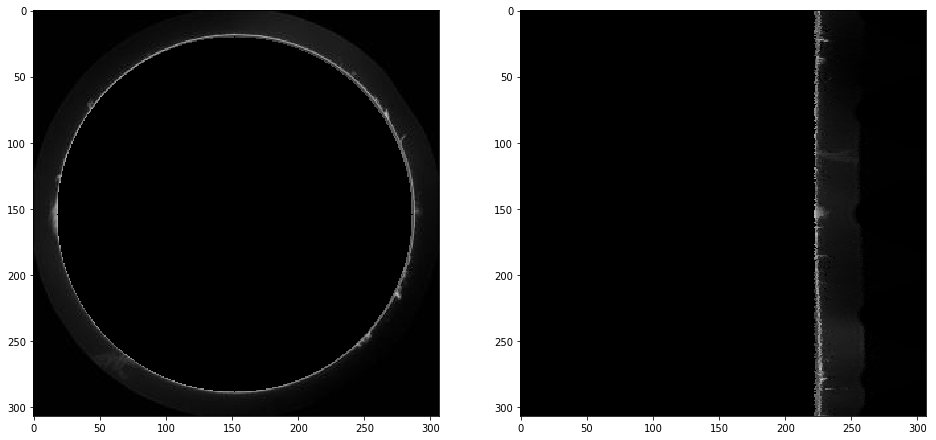

In [7]:
fig2 = plt.figure(figsize=(16,10))
plt.subplot(1, 2, 1)
plt.imshow(a)


plt.subplot(1, 2, 2)
plt.imshow(flat)


plt.show()

In [8]:
flat_g = cv2.cvtColor(flat, cv2.COLOR_BGR2GRAY)
rows,cols = flat_g.shape

M = cv2.getRotationMatrix2D((cols/2,rows/2),90,1)
dst = cv2.warpAffine(flat_g,M,(cols,rows))

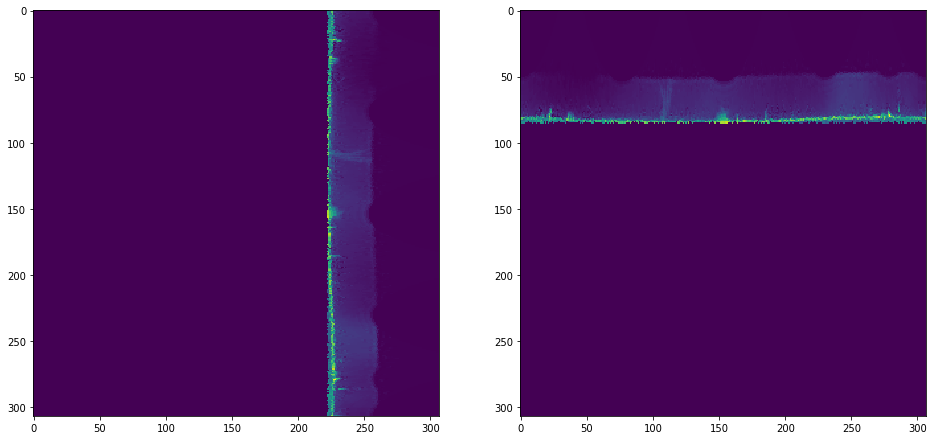

In [9]:
fig3 = plt.figure(figsize=(16,10))
plt.subplot(1, 2, 1)
plt.imshow(flat_g)


plt.subplot(1, 2, 2)
plt.imshow(dst)


plt.show()

In [10]:
cropped = dst[40:100,:]



In [11]:
mean_int=np.mean(cropped[np.nonzero(cropped)])
median_int=np.median(cropped[np.nonzero(cropped)])
print(mean_int)
print(median_int)

24.892010038047438
18.0


In [12]:
ret,thresh4 = cv2.threshold(cropped,1.35*mean_int,0,cv2.THRESH_TOZERO)
#blur = cv2.GaussianBlur(cropped, (1,1),0)
#blur = cv2.bilateralFilter(cropped,5,33,33)


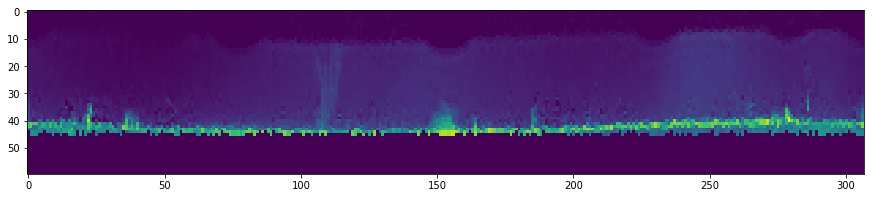

In [13]:
fig4 = plt.figure(figsize=(15,60))

plt.imshow(cropped)


plt.show()

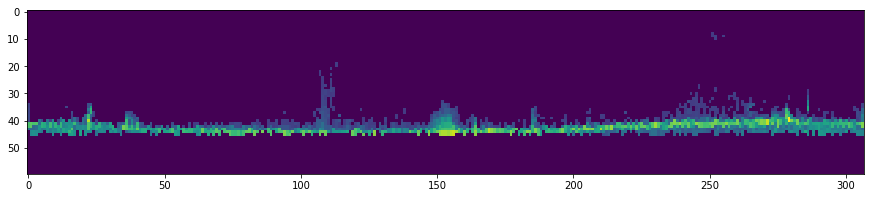

In [14]:

fig5 = plt.figure(figsize=(15,30))

plt.imshow(thresh4)


plt.show()

(60, 307)
(307,)


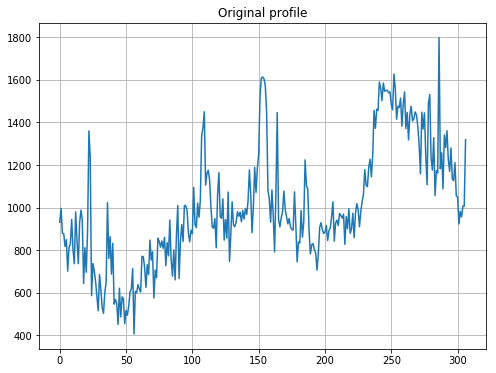

In [15]:
cropped_1D = np.sum(cropped, axis=0)
print(cropped.shape)
print(cropped_1D.shape)
fig7 = plt.figure(figsize=(8,6))

plt.plot(np.arange(np.shape(cropped)[1]), cropped_1D)
plt.grid()
plt.title('Original profile')
plt.show()

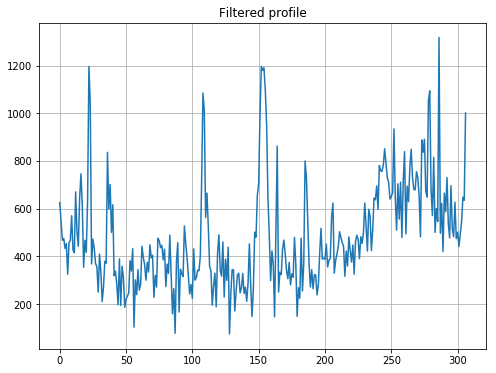

In [16]:
filtered_1D = np.sum(thresh4, axis=0)

fig8 = plt.figure(figsize=(8,6))
plt.plot(np.arange(np.shape(cropped)[1]), filtered_1D)
plt.grid()
plt.title('Filtered profile')

plt.show()

In [17]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[int((window_len/2-1)):-int(window_len/2)]



In [18]:
smoothed_1D = smooth(filtered_1D)
sm_len = len(smoothed_1D)
x = np.arange(sm_len)

In [19]:
print(sm_len)

308


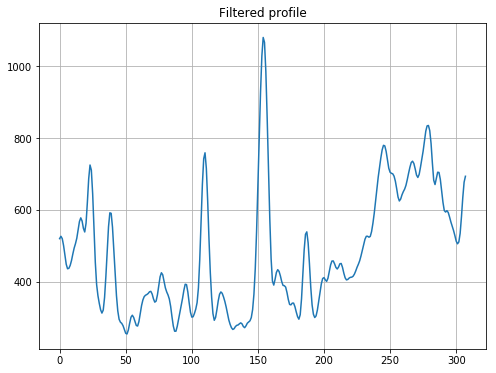

In [20]:
fig9 = plt.figure(figsize=(8,6))
plt.plot(x, smoothed_1D)

plt.grid()
plt.title('Filtered profile')

plt.show()

In [21]:
import pandas as pd
from scipy import signal

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

/home/laura/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


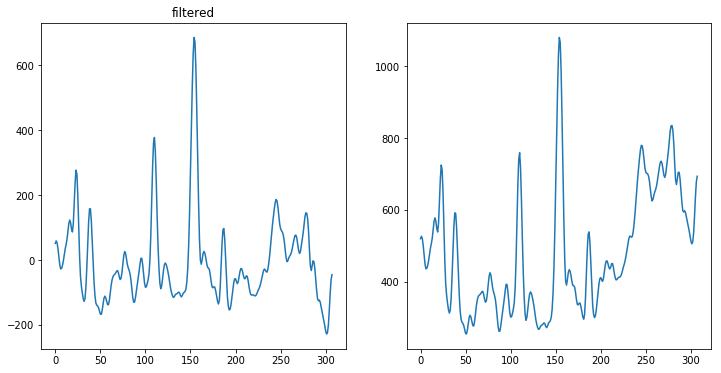

In [22]:
filtered = butter_highpass_filter(smoothed_1D, 0.04, 12, order=5)
fig90 = plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(x, filtered)
plt.title('filtered')


plt.subplot(1, 2, 2)
plt.plot(x, smoothed_1D)


plt.show()

In [23]:
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [24]:
def gaussian(x,*p) :
    # A gaussian peak with:
    #   Constant Background          : p[0]
    #   Peak height above background : p[1]
    #   Central value                : p[2]
    #   Standard deviation           : p[3]
    return p[0]+p[1]*np.exp(-1*(x-p[2])**2/(2*p[3]**2))
def lorentzian(x,a,x0,w) :
    # A lorentzian peak with:
    #   Constant Background          : p[0]
    #   Peak height above background : p[1]
    #   Central value                : p[2]
    #   Full Width at Half Maximum   : p[3]
    return (a/np.pi)/(1.0+((x-x0)/w)**2)

In [25]:
sm_max = np.max(smoothed_1D)
sm_argmax = np.argmax(smoothed_1D)
sm_std = np.std(smoothed_1D)

sm_min =np.r_[True, smoothed_1D[1:] < smoothed_1D[:-1]] & np.r_[smoothed_1D[:-1] < smoothed_1D[1:], True]
sm_argmin = np.where(sm_min==True)
sm_argmin = np.asarray(sm_argmin[0])
sm_argmin= np.append(sm_argmin, x[-1])

new_curve = smoothed_1D.copy()
parameters = list()
ranges = list()
covariances = list()


In [26]:
sm_argmin

array([  0,   6,  19,  32,  51,  59,  72,  88, 100, 117, 131, 140, 162,
       175, 181, 193, 202, 210, 217, 234, 257, 271, 284, 292, 301, 307])

In [27]:
while sm_max > 3*sm_std:
    if (sm_argmax != sm_len -1) & (sm_argmax > sm_argmin[0]):
        min1 = sm_argmin[np.where((sm_argmin<sm_argmax))[0]][-1]
        min2 = sm_argmin[np.where((sm_argmin>sm_argmax))[0]][0]
        x_range =x[min1:min2]
        y_range = smoothed_1D[min1:min2]
        amp = sm_max
        mean = sm_argmax
        sigma = np.std(y_range)
        lore_mod = LorentzianModel(prefix='lore_')
        line_mod = LinearModel(prefix='line_')

        #p=[amp,mean,3*sigma]
        if len(x_range)>3:
            #popt,pcov = curve_fit(gaus,x_range,y_range,p0=[amp,mean,sigma])
            #popt,pcov = curve_fit(lorentzian,x_range,y_range,p)
            pars = line_mod.make_params(intercept=y_range.min(), slope=0)

            pars += lore_mod.guess(y_range, x=x_range)
           

            mod = lore_mod + line_mod
            out = mod.fit(y_range, pars, x=x_range)
            ranges.append(np.asarray((min1,min2)))
            #perr = np.sqrt(np.diag(pcov))

            parameters.append(out)              
            #covariances.append(perr)
            peak = np.zeros(sm_len)
            #peak[min1:min2]=lorentzian(x[min1:min2],*popt )
            #peak[min1:min2]=gaus(x[min1:min2],*popt )
            peak[min1:min2]=out.best_fit


            new_curve = new_curve - peak
            sm_max = np.max(new_curve)
            sm_argmax = np.argmax(new_curve)
        else: 
            new_curve[sm_argmax]=0
            sm_max = np.max(new_curve)
            sm_argmax = np.argmax(new_curve)
    else:
        new_curve[sm_argmax]=0
        sm_max = np.max(new_curve)
        sm_argmax = np.argmax(new_curve)

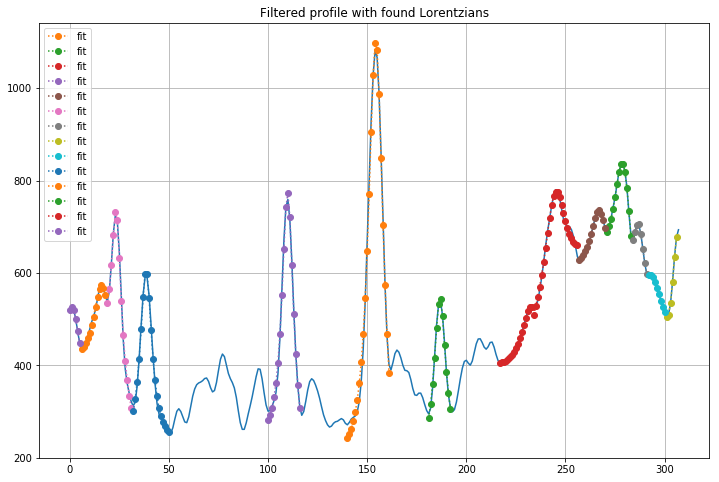

In [28]:
fig10 = plt.figure(figsize=(12,8))
plt.plot(x, smoothed_1D)
for i in range(len(parameters)):
    #plt.plot(x[ranges[i][0]:ranges[i][1]],gaus(x[ranges[i][0]:ranges[i][1]],*parameters[i]),'o:',label=covariances[i])
    #plt.plot(x[ranges[i][0]:ranges[i][1]],lorentzian(x[ranges[i][0]:ranges[i][1]],*parameters[i]),'o:',label='fit')
    plt.plot(x[ranges[i][0]:ranges[i][1]],parameters[i].best_fit,'o:',label='fit')

plt.grid()
plt.title('Filtered profile with found Lorentzians')
plt.legend()
plt.show()

In [29]:
centers = np.asarray([i.best_values['lore_center'] for i in parameters])
amplitudes = np.asarray([i.best_values['lore_amplitude'] for i in parameters])
sigmas = np.asarray([i.best_values['lore_sigma'] for i in parameters])
h = np.asarray([np.max(parameters[i].best_fit)-np.min(parameters[i].best_fit) for i in range(len(parameters))])
norm_h = h/np.max(h)

In [30]:
norm_h

array([1.        , 0.18205425, 0.3111794 , 0.57280376, 0.12641247,
       0.4971574 , 0.12600902, 0.20078795, 0.0950924 , 0.4015577 ,
       0.16188678, 0.30283706, 0.14237536, 0.09117677])

In [31]:
some_centers = centers[np.where(norm_h> 0.1)[0]]
some_amplitudes = amplitudes[np.where(norm_h>0.1)[0]]
some_sigmas = sigmas[np.where(norm_h>0.1)[0]]
some_normh = norm_h[np.where(norm_h>0.1)[0]]

In [32]:
help(cv2.circle)

Help on built-in function circle:

circle(...)
    circle(img, center, radius, color[, thickness[, lineType[, shift]]]) -> img
    .   @brief Draws a circle.
    .   
    .   The function cv::circle draws a simple or filled circle with a given center and radius.
    .   @param img Image where the circle is drawn.
    .   @param center Center of the circle.
    .   @param radius Radius of the circle.
    .   @param color Circle color.
    .   @param thickness Thickness of the circle outline, if positive. Negative values, like #FILLED,
    .   mean that a filled circle is to be drawn.
    .   @param lineType Type of the circle boundary. See #LineTypes
    .   @param shift Number of fractional bits in the coordinates of the center and in the radius value.



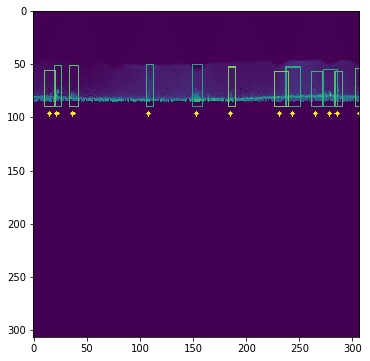

In [37]:
font = cv2.FONT_HERSHEY_SIMPLEX

for i in np.arange(len(some_centers)):
    a = int(150+5*i)
    cv2.circle(dst,(int(some_centers[i]-1),97), 2, (255,255,255), -1)
    cv2.rectangle(dst,(int(some_centers[i]-some_sigmas[i]),int(1/some_normh[i])+50),(int(some_centers[i]+some_sigmas[i]),90),(a,255,255),1)
    #cv2.putText(dst,str(i+1),(int(some_centers[i]-1),97), font, 0.2,(a,255,255),1)
fig73, ax = plt.subplots(figsize=(10, 6))
ax.imshow(dst)
plt.show()

In [38]:
rows1,cols1 = dst.shape

M1 = cv2.getRotationMatrix2D((cols1/2,rows1/2),-90,1)
rot = cv2.warpAffine(dst,M1,(cols1,rows1))

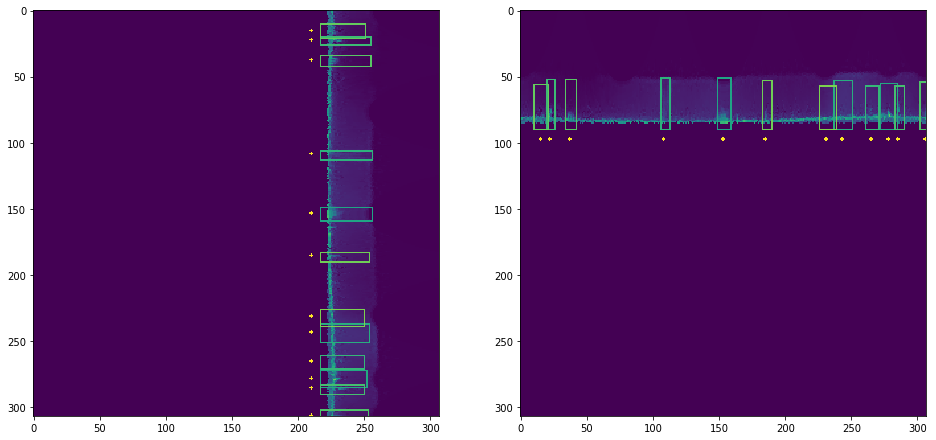

In [35]:
fig30 = plt.figure(figsize=(16,10))
plt.subplot(1, 2, 1)
plt.imshow(rot)


plt.subplot(1, 2, 2)
plt.imshow(dst)


plt.show()

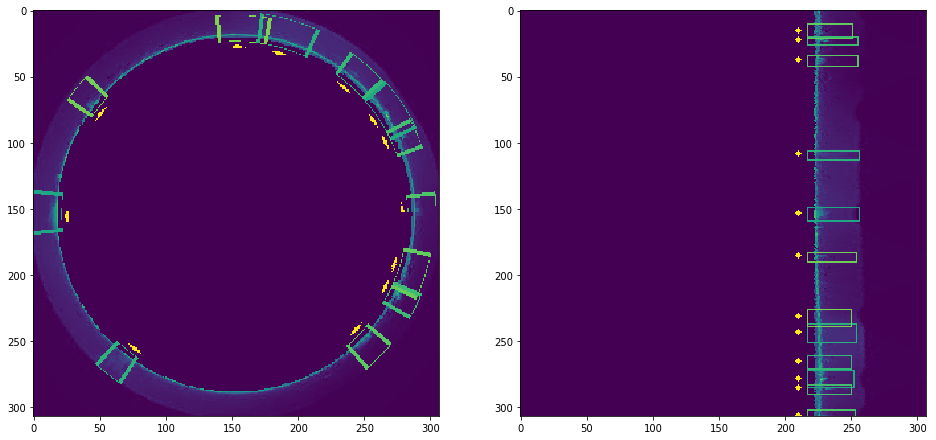

In [39]:
recover = cv2.linearPolar(rot, center,r+50,cv2.WARP_FILL_OUTLIERS+cv2.WARP_INVERSE_MAP)
fig20 = plt.figure(figsize=(16,10))
plt.subplot(1, 2, 1)
plt.imshow(recover)


plt.subplot(1, 2, 2)
plt.imshow(rot)


plt.show()